# Deep Instruments

Using a Generative Adversarial Network to generate artifical instrument sounds.

In [1]:
%matplotlib inline
# %tensorflow_version 2.x

# To use specific version

# !pip install --user tensorflow==2.1

# Download Samples

In [2]:
!rm -rf samples

# !wget --no-check-certificate https://muthanna.com/deepears/samples-v3.zip
# !wget --no-check-certificate https://muthanna.com/deepears/sweetchild-8bit.wav
# !wget --no-check-certificate https://muthanna.com/deepears/deepears_chord_model.h5
# !wget --no-check-certificate https://muthanna.com/deepears/deepears_root_model.h5

!wget --no-check-certificate https://muthanna.com/deepears/instrument-samples-v1.zip
!unzip -q instrument-samples-v1.zip
!ls -l samples/ | wc -l
!ls -l samples | head

--2020-03-10 17:16:13--  https://muthanna.com/deepears/instrument-samples-v1.zip
Resolving muthanna.com (muthanna.com)... 35.244.227.152
Connecting to muthanna.com (muthanna.com)|35.244.227.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 585407085 (558M) [application/zip]
Saving to: ‘instrument-samples-v1.zip.2’

instrument-samples- 100%[===================>] 558.29M  65.4MB/s    in 8.6s    

2020-03-10 17:16:22 (64.7 MB/s) - ‘instrument-samples-v1.zip.2’ saved [585407085/585407085]

8998
total 791736
-rw-r--r-- 1 jupyter jupyter 88244 Mar  4 19:45 note-A2-P0-110.000-S0-V0.59-noreject-instrument.wav
-rw-r--r-- 1 jupyter jupyter 88244 Mar  4 19:45 note-A2-P0-152.000-S42-V0.52-noreject-instrument.wav
-rw-r--r-- 1 jupyter jupyter 88244 Mar  4 19:45 note-A2-P0-152.000-S42-V0.5-noreject-instrument.wav
-rw-r--r-- 1 jupyter jupyter 88242 Mar  4 19:45 note-A2-P0-154.000-S44-V0.83-noreject-instrument.wav
-rw-r--r-- 1 jupyter jupyter 88244 Mar  4 19:45 note-A2-P0-16

In [3]:
import os
files = os.listdir("samples")
len(files)

8997

In [4]:
%matplotlib inline

import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

class Config:
  def __init__(self,
      rows=513,        # Rows: number of FFT bins + 1
      cols = 327,      # Cols: number of time-slices
      s_nperseg = 32,  # Size of segment windowed and processed (in samples)
      s_nfft = 1024,    # FFT size. If > nperseg, then zero-padded on both sides
      s_noverlap = 24, # STFT overlap, the more overlap, the more cols
      resample = 0,    # Resample (hz): if not zero, resample audio before processing
      log_scale = False, # Return log scaled data
      no_spectrogram = False, # Return time-domain data (resampled to rows * cols data points)
      slice_start_s = 0, # Slice start time (seconds)
      slice_duration_s = 0 # Slice duration (seconds)
  ):
    self.rows = rows
    self.cols = cols
    self.s_nperseg = s_nperseg
    self.s_nfft = s_nfft
    self.s_noverlap = s_noverlap
    self.log_scale = log_scale
    self.resample = resample
    self.no_spectrogram = no_spectrogram
    self.slice_start_s = slice_start_s
    self.slice_duration_s = slice_duration_s

config = Config(
    rows=128,
    cols = 72,
    s_nperseg = 256,
    s_nfft = 256,
    s_noverlap = 47,
    log_scale = True,
    resample = 16000)

DefaultConfig = config

def play_file(file, config=DefaultConfig):
  fs, data = wavfile.read(file)
  if config.resample > 0:
    number_of_samples = round(len(data) * float(config.resample) / fs)
    data = signal.resample(data, number_of_samples)
    fs = config.resample

  display.display(display.Audio(data, rate=fs))

def spectrogram(file=None, data=None, fs=None, transpose=False, render=True, config=DefaultConfig):
  if data is None:
    fs, data = wavfile.read(file)
    if config.resample > 0:
      number_of_samples = round(len(data) * float(config.resample) / fs)
      data = signal.resample(data, number_of_samples)
      fs = config.resample

  if config.slice_start_s > 0:
    start_sample = config.slice_start_s * fs
    end_sample = start_sample + (config.slice_duration_s * fs)
    data = data[start_sample:end_sample]

  f, t, Sxx = signal.spectrogram(data, fs,
          window=('hann'),
          nperseg=config.s_nperseg,
          nfft=config.s_nfft,
          noverlap=config.s_noverlap,
          mode='complex')
  
  xlabel = 'Frequency (Hz)'
  ylabel = 'Time (sec)'

  if transpose:
    (f, t) = (t, f)
    (xlabel, ylabel) = (ylabel, xlabel)
    Sxx = np.transpose(Sxx)

  if render:
    print("Spectrogram for", file)
    mags = np.absolute(Sxx) 

    if config.log_scale:
      np.log(mags, out=mags)
  
    plt.pcolormesh(t, f, mags, cmap='viridis')
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    print(Sxx.shape)
  
  return f, t, Sxx

def spectrogram_to_audio(Sxx, config=DefaultConfig):
  t, x = signal.istft(Sxx, config.resample,
       window=('hann'),
       nperseg=config.s_nperseg,
       nfft=config.s_nfft,
       noverlap=config.s_noverlap)
  
  display.display(display.Audio(x, rate=config.resample))
  return t, x
  

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

def plot_regression_history(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

Spectrogram for samples/note-Ds2-P6-95.782-S18-V0.39-noreject-instrument.wav
(129, 76)
Spectrogram for samples/note-Cs3-P42-196.591-S58-V0.63-noreject-instrument.wav
(129, 76)
Spectrogram for samples/note-Cs6-P65-1127.731-S19-V0.94-noreject-instrument.wav
(129, 76)
Spectrogram for samples/note-E6-P61-1318.510-S0-V0.79-noreject-instrument.wav
(129, 76)
Spectrogram for samples/note-Ds3-P56-232.563-S77-V0.42-noreject-instrument.wav
(129, 76)
Spectrogram for samples/note-E2-P0-93.407-S11-V0.44-noreject-instrument.wav
(129, 76)
Spectrogram for samples/note-Fs2-P30-114.499-S22-V0.75-noreject-instrument.wav
(129, 76)
Spectrogram for samples/note-G2-P56-135.999-S38-V0.92-noreject-instrument.wav
(129, 76)


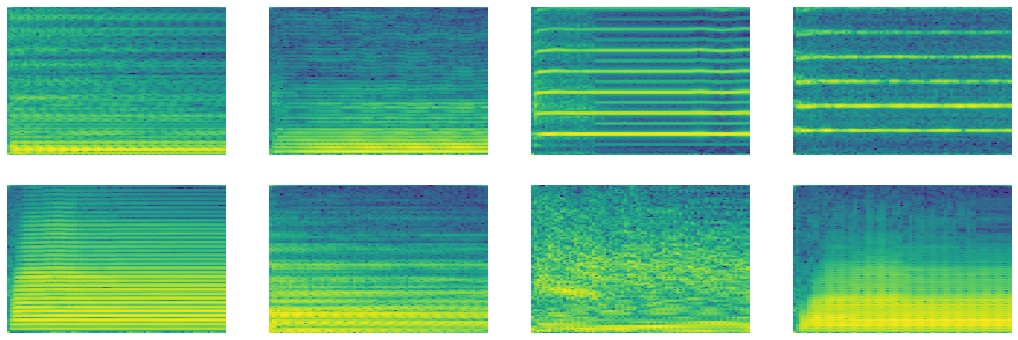

In [5]:
plt.figure(figsize=(18, 6))
for i in range(0, 8):
  plt.subplot(2, 4, i+1)
  plt.axis('off')
  spectrogram('samples/'+files[i], config=config)

plt.show()

Spectrogram for samples/note-Ds3-P11-165.563-S10-V0.31-noreject-instrument.wav
(129, 76)


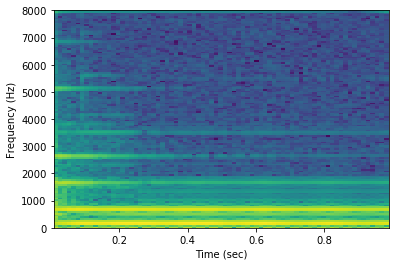

Spectrogram for None
(129, 74)


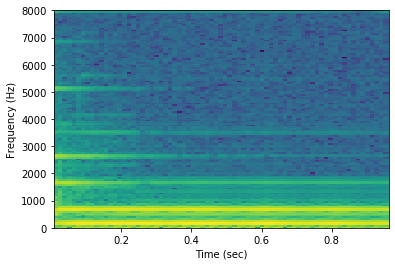

In [6]:
example = 'samples/'+files[3400]

play_file(example)
f, t, Sxx = spectrogram(example, config=config)
plt.show()
t2, data2 = spectrogram_to_audio(Sxx, config=config)
f, t, Sxx = spectrogram(data=data2, fs=config.resample, config=config)
plt.show()

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import re
import sys
import os
from keras.utils.np_utils import to_categorical

class DeepSamples:
  @staticmethod
  def note_parts(f):
    parts = f.split("-")
    partmap = {
        "note": parts[1],
        "patch": parts[2],
        "freq": float(parts[3]),
        "shift": parts[4],
        "volume": parts[5],
        "reject": parts[6],
        "envelope": parts[7],
    }

    matches = re.match('([A-G]+[bs]?)(\d*)', parts[1])
    partmap["root"] = matches.group(1)
    partmap["octave"] = matches.group(2)
    return partmap

  def __init__(self, dir_name="./samples", num_samples=100, split=0.8, config=DefaultConfig):
    self.config = config
    self.dir_name = dir_name  # path to samples
    self.num_samples = num_samples # number of samples to load
    self.split = split  # training/testing split
    self.training_size = int(self.num_samples * self.split)
    self.testing_size = self.num_samples - self.training_size
    
  def get_config(self):
    return self.config

  def load(self):
    print("Loading sample files...")
    files = os.listdir(self.dir_name)
    print("Shuffling samples...")
    np.random.shuffle(files)
    print("Generating spectrograms...")
    xs = np.empty((self.num_samples, self.config.rows, self.config.cols), dtype="complex64")
    for i, file in enumerate(files[:self.num_samples]):
      xs[i] = self.spectrogram(os.path.join(self.dir_name, file))

    # Normalize data
    self.training_xs = np.abs(xs[:self.training_size])
    self.training_xs_mean = np.mean(self.training_xs)
    self.training_xs_std = np.std(self.training_xs)
    self.training_xs -= self.training_xs_mean
    self.training_xs /= self.training_xs_std

    self.testing_xs = np.abs(xs[self.training_size:])
    self.testing_xs_mean = np.mean(self.testing_xs)
    self.testing_xs_std = np.std(self.testing_xs)
    self.testing_xs -= self.testing_xs_mean
    self.testing_xs /= self.testing_xs_std

  def get_xs(self):
    return (self.training_xs, self.testing_xs)

  def spectrogram(self, file):
    f, t, Sxx = spectrogram(file, config=self.config, render=False)
    return Sxx[:self.config.rows,:self.config.cols]

Using TensorFlow backend.


In [8]:
samples = DeepSamples(config=DefaultConfig)
samples.load()

Loading sample files...
Shuffling samples...
Generating spectrograms...


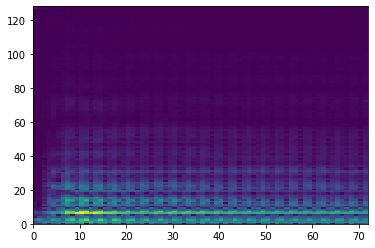

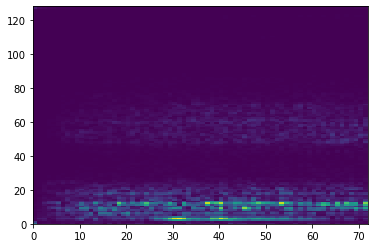

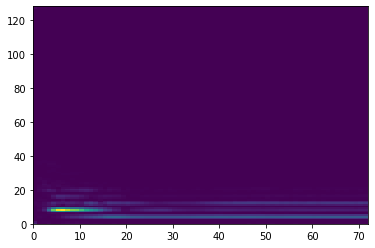

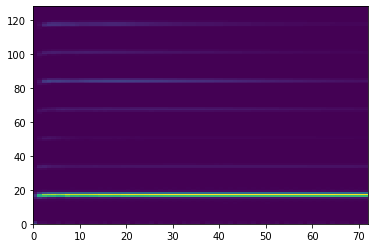

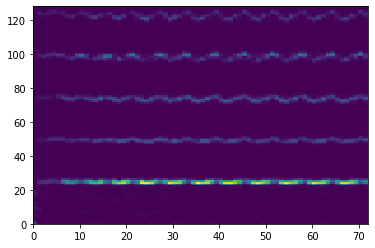

In [11]:
x = samples.get_xs()[0]
for i in range(0, 5):
  # data = x[i][:config.rows,:] + 1j * x[i][config.rows:,:]
  # spectrogram_to_audio(data, config=DefaultConfig)
  plt.pcolormesh(x[i])
  plt.show()

In [12]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [14]:
noise_dim = 100
def make_generator_model(config=DefaultConfig, noise_dim=noise_dim):
    rows = config.rows
    cols = config.cols
    print("Starting with:", rows, cols)
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(int(rows/8)*int(cols/8)*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((int(rows/8), int(cols/8), 256)))
    print(model.output_shape)
    assert model.output_shape == (None, int(rows/8), int(cols/8), 256) # Note: None is the batch size
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, int(rows/4), int(cols/4), 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, int(rows/2), int(cols/2), 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    print(model.output_shape)
    assert model.output_shape == (None, rows, cols, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    print(model.output_shape)
    assert model.output_shape == (None, rows, cols, 1)

    return model

with mirrored_strategy.scope():
    generator = make_generator_model()

generator.summary()

Starting with: 128 72
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(None, 16, 9, 256)
(None, 32, 18, 128)
(None, 64, 36, 64)
(None, 128, 72, 32)
(None, 128, 72, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 36864)             3686400   
_________________________________________________________________
batch_normalization_4 (Batch (None, 36864)             147456    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 36864)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 9, 256)    

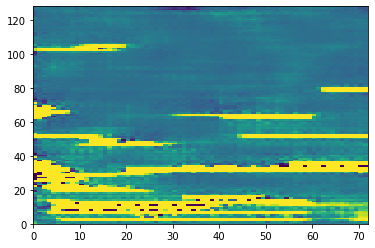

In [40]:
def display_audio(audio, config=DefaultConfig, play=True):
  audio = audio.reshape(config.rows, config.cols)
  # audio = audio[:config.rows,:] + 1j * audio[config.rows:,:]
  # image = np.log(np.absolute(audio))
  plt.pcolormesh(audio)
  if False: #play
    audio_data = spectrogram_to_audio(audio, config=config)
    display.display(audio_data)

noise = tf.random.normal([1, noise_dim])
display_audio(generator(noise, training=False).numpy())

In [36]:
def make_discriminator_model(config=DefaultConfig):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(config.rows, config.cols, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu")) # NEW!
    model.add(layers.Dense(1))

    return model

with mirrored_strategy.scope():
    discriminator = make_discriminator_model()
    
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 64, 36, 64)        1664      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 64, 36, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 64, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 18, 128)       204928    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 18, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 18, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 9, 128)       

In [21]:
with mirrored_strategy.scope():
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
# tf.config.experimental_run_functions_eagerly(True)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(dist_images, batch_size=32, noise_dim=100):
    def step_fn(inputs):
        print("step_fn", inputs.shape)
        noise = tf.random.normal([batch_size, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          generated_images = generator(noise, training=True)

          real_output = discriminator(inputs, training=True)
          fake_output = discriminator(generated_images, training=True)

          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

        print("gen_loss", gen_loss, "disc_loss", disc_loss)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        return gen_loss + disc_loss
   
    print("dist_images", dist_images.shape)
    per_example_losses = mirrored_strategy.experimental_run_v2(step_fn, args=(dist_images,))
    print("per_example_losses", per_example_losses)
    # return mirrored_strategy.reduce(tf.distribute.ReduceOp.MEAN, per_example_losses, axis=0) # mean loss

In [24]:
import time

def train(dataset, epochs, batch_size=32, noise_dim=100, seed=tf.random.normal([16, 100])):
  for epoch in range(epochs):
    start = time.time()
    print("Epoch", epoch, "at", start)

    with mirrored_strategy.scope():
        for i in range(len(dataset)):
          image_batch = dataset[i]
          print("Batch", i, image_batch.shape)
          train_step(image_batch, batch_size=batch_size, noise_dim=noise_dim)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [25]:
import pathlib
pathlib.Path("images").mkdir(parents=True, exist_ok=True)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(12,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      prediction = predictions[i, :, :, 0]
      display_audio(prediction.numpy(), play=False)
      # plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

        
  plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [27]:
num_batches = 500
batch_size = 16
seed = tf.random.normal([batch_size, noise_dim])

prod_samples = DeepSamples(config=DefaultConfig, num_samples=batch_size*num_batches, split=1)
prod_samples.load()

training_samples = prod_samples.get_xs()[0]
images = np.reshape(training_samples, (num_batches, batch_size, config.rows, config.cols, 1))

Loading sample files...
Shuffling samples...
Generating spectrograms...


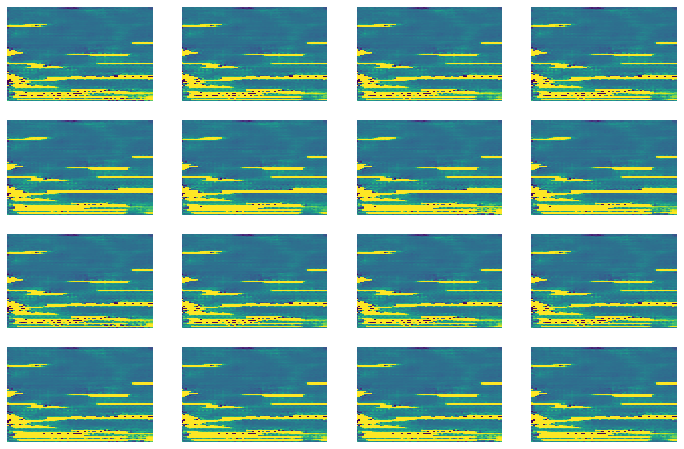

In [33]:
train(images, 150, noise_dim=noise_dim, batch_size=batch_size, seed=seed)

In [112]:
!ls -l training_checkpoints/
!rm -f checkpoints.zip 
!zip -r checkpoints.zip training_checkpoints 

total 709080
-rw-r--r-- 1 root root        69 Mar  4 22:58 checkpoint
-rw-r--r-- 1 root root      8025 Mar  4 22:58 ckpt-1.data-00000-of-00002
-rw-r--r-- 1 root root 726075188 Mar  4 22:58 ckpt-1.data-00001-of-00002
-rw-r--r-- 1 root root      3944 Mar  4 22:58 ckpt-1.index
  adding: training_checkpoints/ (stored 0%)
  adding: training_checkpoints/ckpt-1.data-00001-of-00002


zip error: Interrupted (aborting)
